# Preprocessing the data of scRNA-seq with omicverse[GPU]

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
   ‚ÄúDue to recent updates in `rapids_singlecell`, the pure-GPU version is currently unavailable. We plan to fix this in a future release and support datasets with tens of millions of cells.‚Äù
  </p>
</div>

The count table, a numeric matrix of genes‚Äâ√ó‚Äâcells, is the basic input data structure in the analysis of single-cell RNA-sequencing data. A common preprocessing step is to adjust the counts for variable sampling efficiency and to transform them so that the variance is similar across the dynamic range. 

Suitable methods to preprocess the scRNA-seq is important. Here, we introduce some preprocessing step to help researchers can perform downstream analysis easyier.

User can compare our tutorial with [scanpy'tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) to learn how to use omicverse well


## Installation

Note that the GPU module is not directly present and needs to be installed separately, for a detailed [tutorial](https://rapids-singlecell.readthedocs.io/en/latest/index.html) see [https://rapids-singlecell.readthedocs.io/en/latest/index.html](https://rapids-singlecell.readthedocs.io/en/latest/index.html)

### conda-env
Note that in order to avoid conflicts, you'd better follow the step of installation.

```shell
#1. create a new conda env
conda create -n rapids python=3.11
#2. install rapids using conda
conda install rapids=24.04 -c rapidsai -c conda-forge -c nvidia -y   
#3. install cuml
conda install cudf=24.04 cuml=24.04 cugraph=24.04 cuxfilter=24.04 cucim=24.04 pylibraft=24.04 raft-dask=24.04 cuvs=24.04 -c rapidsai -c conda-forge -c nvidia -y   
#4. install rapid_single_cell
pip install rapids-singlecell
#5. install omicverse
curl -sSL https://raw.githubusercontent.com/Starlitnightly/omicverse/refs/heads/master/install.sh | bash -s
```

Here, we install the `rapids==24.04`, that's because our system's `glibc<2.28`. You can follow the official tutorial to install the latest version of rapids.

In [1]:
import scanpy as sc
import omicverse as ov
ov.plot_set(font_path='Arial')

# Enable auto-reload for development
%load_ext autoreload
%autoreload 2

/oak/stanford/groups/xiaojie/steorra/env/rapid/lib/python3.11/site-packages/omicverse/utils/_data.py:324: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


üî¨ Starting plot initialization...
Arial font downloaded successfully to: /tmp/omicverse_arial.ttf
Registered as: Arial
üß¨ Detecting CUDA devices‚Ä¶
‚úÖ [GPU 0] NVIDIA H100 80GB HBM3
    ‚Ä¢ Total memory: 79.1 GB
    ‚Ä¢ Compute capability: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

üîñ Version: 1.7.6rc1   üìö Tutorials: https://omicverse.readthedocs.io/
‚úÖ plot_set complete.



In [2]:
ov.settings.gpu_init()

GPU mode activated


The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [5]:
# !mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [6]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
adata

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


AnnData object with n_obs √ó n_vars = 2700 √ó 32738
    var: 'gene_ids'

In [7]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

## Preprocessing

### Quantity control

For single-cell data, we require quality control prior to analysis, including the removal of cells containing double cells, low-expressing cells, and low-expressing genes. In addition to this, we need to filter based on mitochondrial gene ratios, number of transcripts, number of genes expressed per cell, cellular Complexity, etc. For a detailed description of the different QCs please see the document: https://hbctraining.github.io/scRNA-seq/lessons/04_SC_quality_control.html

In [8]:
ov.pp.anndata_to_GPU(adata)

Data has been moved to GPU
Don`t forget to move it back to CPU after analysis is done
Use `ov.pp.anndata_to_CPU(adata)`


In [9]:
%%time
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250},
              batch_key=None)
adata

üöÄ Using RAPIDS GPU to calculate QC...

üîç Quality Control Analysis (GPU-Accelerated):
   Dataset shape: 2,700 cells √ó 32,738 genes
   QC mode: seurat
   Doublet detection: scrublet
   Mitochondrial genes: MT-
   üöÄ Loading data to GPU...

üìä Step 1: Calculating QC Metrics
   Mitochondrial genes (prefix 'MT-'): 13 found
   ‚úì QC metrics calculated:
     ‚Ä¢ Mean nUMIs: 2367 (range: 548-15844)
     ‚Ä¢ Mean genes: 847 (range: 212-3422)
     ‚Ä¢ Mean mitochondrial %: 2.2% (max: 22.6%)
   üìà Original cell count: 2,700

üîß Step 2: Quality Filtering (SEURAT)
   Thresholds: mito‚â§0.2, nUMIs‚â•500, genes‚â•250
   üìä Seurat Filter Results:
     ‚Ä¢ nUMIs filter (‚â•500): 0 cells failed (0.0%)
     ‚Ä¢ Genes filter (‚â•250): 3 cells failed (0.1%)
     ‚Ä¢ Mitochondrial filter (‚â§0.2): 2 cells failed (0.1%)
   ‚úì Combined QC filters: 5 cells removed (0.2%)

üéØ Step 3: Final Filtering
   Parameters: min_genes=200, min_cells=3
   Ratios: max_genes_ratio=1, max_cells_ratio=1
fi

AnnData object with n_obs √ó n_vars = 2689 √ó 13503
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'n_counts', 'n_cells'
    uns: 'scrublet', 'status'

### High variable Gene Detection

Here we try to use Pearson's method to calculate highly variable genes. This is the method that is proposed to be superior to ordinary normalisation. See [Article](https://www.nature.com/articles/s41592-023-01814-1#MOESM3) in *Nature Method* for details.


normalize|HVGsÔºöWe use | to control the preprocessing step, | before for the normalisation step, either `shiftlog` or `pearson`, and | after for the highly variable gene calculation step, either `pearson` or `seurat`. Our default is `shiftlog|pearson`.

- if you use `mode`=`shiftlog|pearson` you need to set `target_sum=50*1e4`, more people like to se `target_sum=1e4`, we test the result think 50*1e4 will be better
- if you use `mode`=`pearson|pearson`, you don't need to set `target_sum`

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    if the version of `omicverse` lower than `1.4.13`, the mode can only be set between `scanpy` and `pearson`.
  </p>
</div>


In [10]:
%%time
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)
adata

Begin robust gene identification
After filtration, 13503/13503 genes are kept.     Among 13503 genes, 13503 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
Time to analyze data in gpu: 6.483870506286621 seconds.
End of size normalization: shiftlog and HVGs selection pearson
CPU times: user 4.87 s, sys: 431 ms, total: 5.3 s
Wall time: 6.49 s


AnnData object with n_obs √ó n_vars = 2689 √ó 13503
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'n_counts', 'n_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'log1p', 'hvg', 'status_args', 'REFERENCE_MANU'
    layers: 'counts'

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [11]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

View of AnnData object with n_obs √ó n_vars = 2689 √ó 2000
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'n_counts', 'n_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'log1p', 'hvg', 'status_args', 'REFERENCE_MANU'
    layers: 'counts'

## Principal component analysis

In contrast to scanpy, we do not directly scale the variance of the original expression matrix, but store the results of the variance scaling in the layer, due to the fact that scale may cause changes in the data distribution, and we have not found scale to be meaningful in any scenario other than a principal component analysis

In [12]:
%%time
ov.pp.scale(adata)
adata

CPU times: user 218 ms, sys: 12 ms, total: 230 ms
Wall time: 271 ms


AnnData object with n_obs √ó n_vars = 2689 √ó 2000
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'n_counts', 'n_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'log1p', 'hvg', 'status_args', 'REFERENCE_MANU'
    layers: 'counts', 'scaled'

If you want to perform pca in normlog layer, you can set `layer`=`normlog`, but we think scaled is necessary in PCA.

In [13]:
%%time
ov.pp.pca(adata,layer='scaled',n_pcs=50)
adata

CPU times: user 24.8 ms, sys: 6.95 ms, total: 31.7 ms
Wall time: 31.5 ms


AnnData object with n_obs √ó n_vars = 2689 √ó 2000
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'n_counts', 'n_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'log1p', 'hvg', 'status_args', 'REFERENCE_MANU', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_pca', 'scaled|original|X_pca'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled'

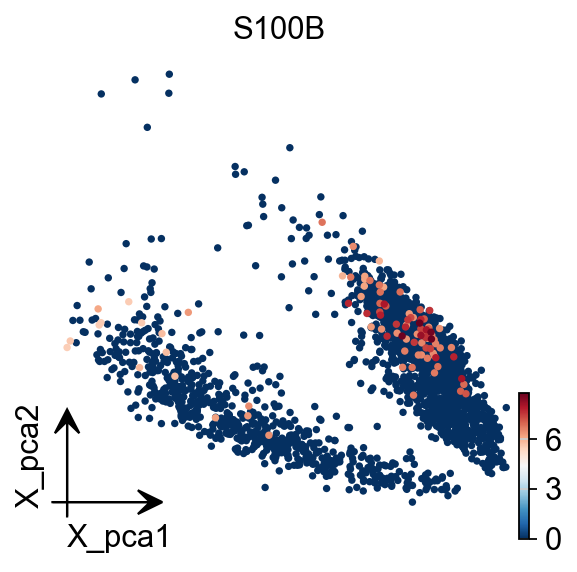

In [17]:
adata.obsm['X_pca']=adata.obsm['scaled|original|X_pca']
ov.pl.embedding(adata,
                  basis='X_pca',
                  color='S100B',
                  frameon='small')

## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [18]:
%%time
ov.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca',
                method='cagra')

üöÄ Using RAPIDS GPU to calculate neighbors...
CPU times: user 2.52 s, sys: 164 ms, total: 2.69 s
Wall time: 19 s


To visualize the PCA‚Äôs embeddings, we use the `pymde` package wrapper in omicverse. This is an alternative to UMAP that is GPU-accelerated.

In [19]:
adata.obsm["X_mde"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])
adata

AnnData object with n_obs √ó n_vars = 2689 √ó 2000
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'n_counts', 'n_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'log1p', 'hvg', 'status_args', 'REFERENCE_MANU', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors'
    obsm: 'X_pca', 'scaled|original|X_pca', 'X_mde'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled'
    obsp: 'distances', 'connectivities'

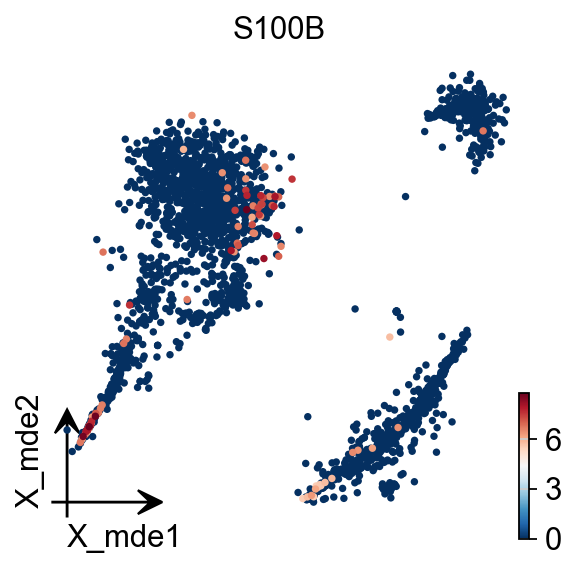

In [20]:
ov.pl.embedding(adata,
                basis='X_mde',
                color='S100B',
                frameon='small')

You also can use `umap` to visualize the neighborhood graph

In [21]:
ov.pp.umap(adata)

üîç [2025-08-02 20:10:38] Running UMAP in 'gpu' mode...
üöÄ Using RAPIDS GPU UMAP...
‚úÖ UMAP completed successfully.


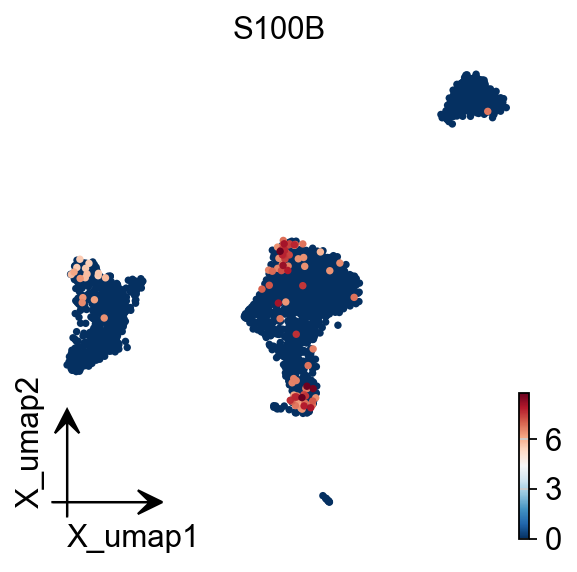

In [22]:
ov.pl.embedding(adata,
                basis='X_umap',
                color='S100B',
                frameon='small')

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [23]:
ov.pp.leiden(adata)

üöÄ Using RAPIDS GPU to calculate Leiden...


In [24]:
ov.pp.anndata_to_CPU(adata)

In [32]:
for i in adata.raw.var_names:
    if 'CD' in i:
        print(i)

CDK11B
CDK11A
PIK3CD
CDA
CDC42
SPOCD1
CCDC28B
NCDN
CDCA8
CCDC30
CCDC23
CDC20
CCDC24
CCDC163P
CDKN2C
CDC7
CCDC18
ABCD3
CDC14A
CD53
CD58
CD2
CD101
CD160
CDC42SE1
C2CD4D
CD1D
CD1A
CD1C
CD1B
CD1E
CD84
CD244
CD247
CDC73
CDK18
CD55
CD46
CCDC121
CDC42EP3
CCDC88A
CCDC104
CCDC142
PTCD3
CD8A
CD8B
CCDC138
CCDC93
CCDC115
CD302
CDCA7
CCDC141
FTCDNL1
CD28
RQCD1
PDCD1
FANCD2
CCDC174
PDCD6IP
PLCD1
CCDC13
CCDC12
CDC25A
CCDC51
CCDC71
PRKCD
CCDC66
CD47
CD96
CD200
CD200R1
CD86
CCDC58
CCDC14
CDV3
PDCD10
TBCCD1
CCDC50
CCDC96
CD38
CCDC149
SCD5
GSTCD
CCDC109B
CDKN2AIP
CCDC127
PDCD6
CCDC152
CD180
CDK7
CCDC125
PTCD2
CCDC112
CDC42SE2
CDKL3
CDKN2AIPNL
CDC23
CD14
CCDC69
NUDCD2
CDYL
CD83
CDKAL1
CDKN1A
CCDC167
CDC5L
CD2AP
CD164
CDC40
CDK19
CCDC28A
PDCD2
CDCA7L
CCDC126
CDK13
NUDCD3
CCDC146
CD36
CDK14
CDK6
CCDC132
PTCD1
CDHR3
CCDC71L
CCDC136
CDK5
SMARCD3
CD99
CDKL5
CDK16
CCDC120
CCDC22
CD40LG
CD99L2
ABCD1
CCDC25
NUDCD1
CCDC26
CDC37L1
CD274
CDKN2A
CDKN2B
CD72
CCDC107
CDK20
BICD2
CDC14B
CCDC180
CDC26
CDK5RAP2
CDK9
FIBCD

We redesigned the visualisation of embedding to distinguish it from scanpy's embedding by adding the parameter `fraemon='small'`, which causes the axes to be scaled with the colourbar

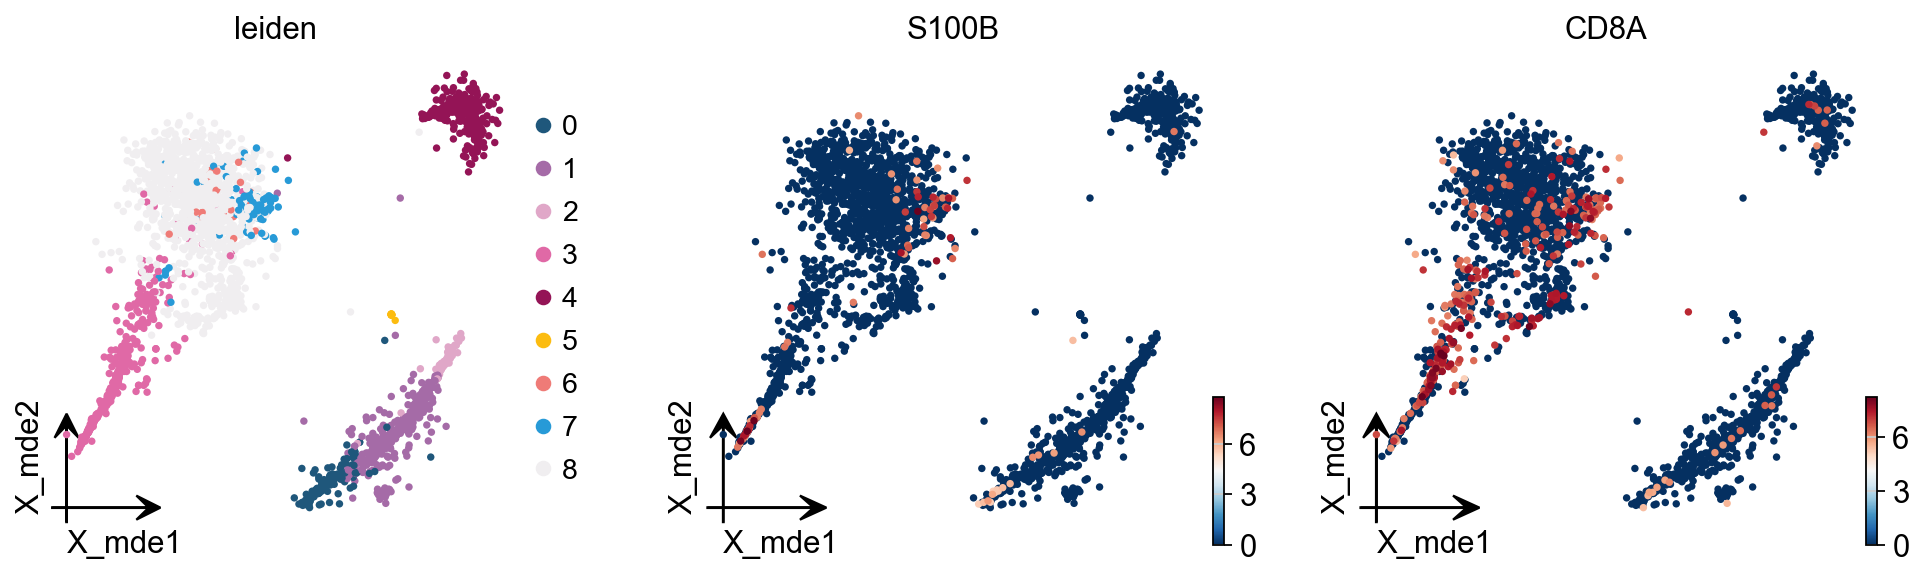

In [33]:
ov.pl.embedding(adata,
                basis='X_mde',
                color=['leiden', 'S100B', 'CD8A'],
                frameon='small')

We also provide a boundary visualisation function `ov.utils.plot_ConvexHull` to visualise specific clusters.

Arguments: 
- color: if None will use the color of clusters
- alpha: default is 0.2

leiden_colors


<Axes: title={'center': 'leiden'}, xlabel='X_mde1', ylabel='X_mde2'>

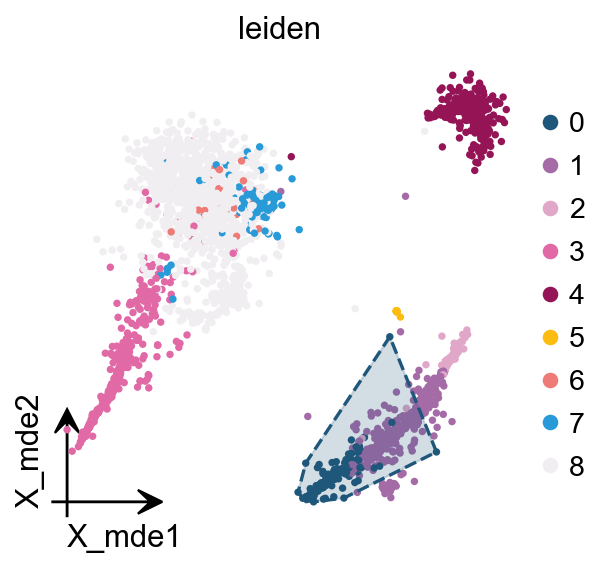

In [34]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots( figsize = (4,4))

ov.pl.embedding(adata,
                basis='X_mde',
                color=['leiden'],
                frameon='small',
                show=False,
                ax=ax)

ov.pl.ConvexHull(adata,
                basis='X_mde',
                cluster_key='leiden',
                hull_cluster='0',
                ax=ax)


If you have too many labels, e.g. too many cell types, and you are concerned about cell overlap, then consider trying the `ov.utils.gen_mpl_labels` function, which improves text overlap.
In addition, we make use of the `patheffects` function, which makes our text have outlines

- adjust_kwargs: it could be found in package `adjusttext`
- text_kwargs: it could be found in class `plt.texts`

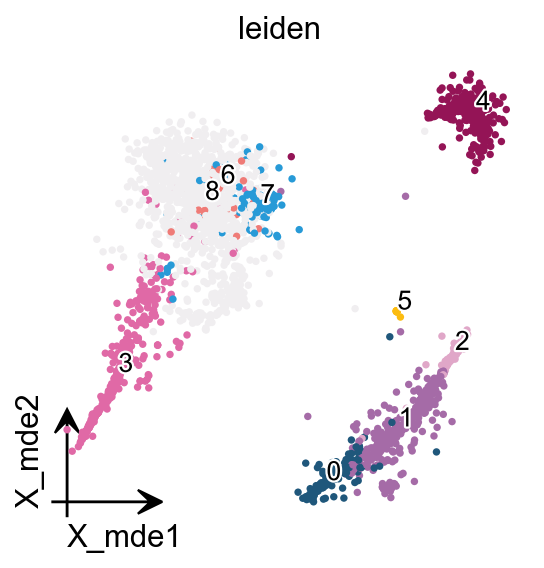

In [35]:
from matplotlib import patheffects
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4))

ov.pl.embedding(adata,
                  basis='X_mde',
                  color=['leiden'],
                   show=False, legend_loc=None, add_outline=False, 
                   frameon='small',legend_fontoutline=2,ax=ax
                 )

ov.utils.gen_mpl_labels(
    adata,
    'leiden',
    exclude=("None",),  
    basis='X_mde',
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize= 12 ,weight='bold',
                     path_effects=[patheffects.withStroke(linewidth=2, foreground='w')] ),
)

In [46]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B',  'CD14',
                'LGALS3', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A',  'PPBP']

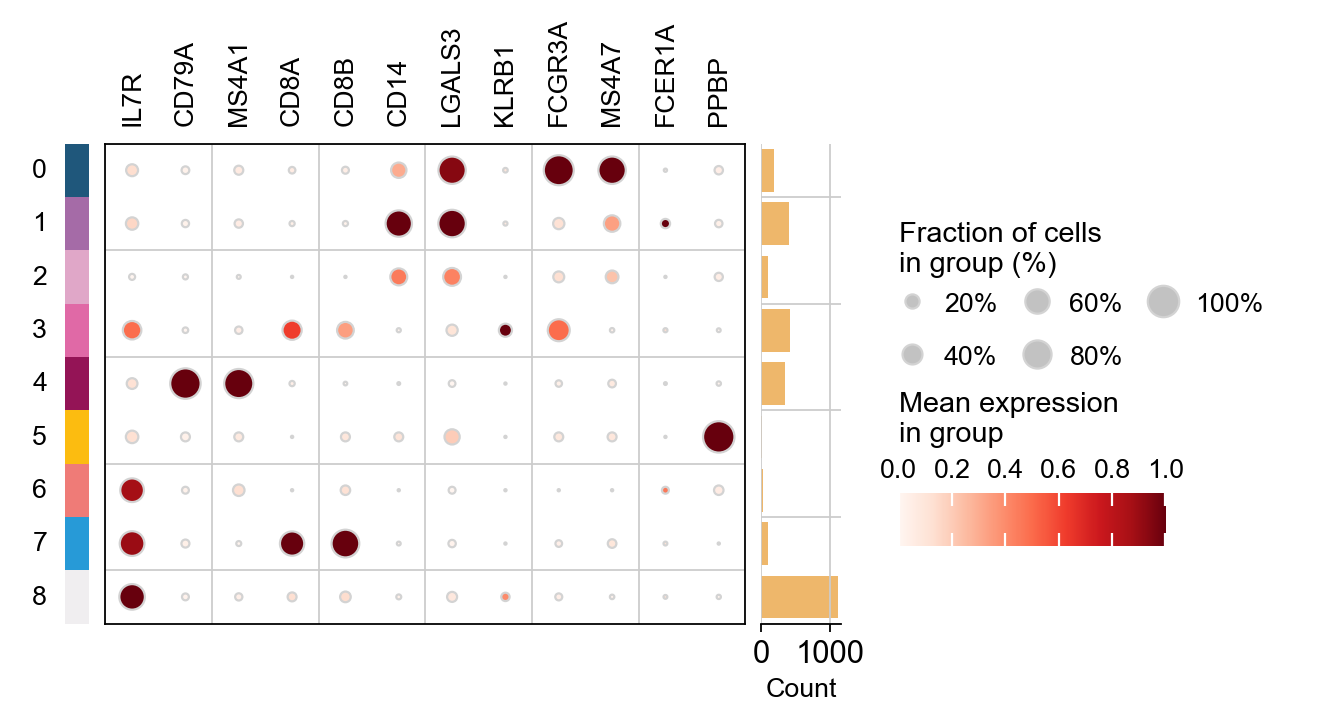

In [47]:
ov.pl.dotplot(adata, marker_genes, groupby='leiden',
             standard_scale='var');

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

Storing dendrogram info using `.uns['dendrogram_leiden']`
ranking genes
    finished: added to `.uns['leiden_ttest']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


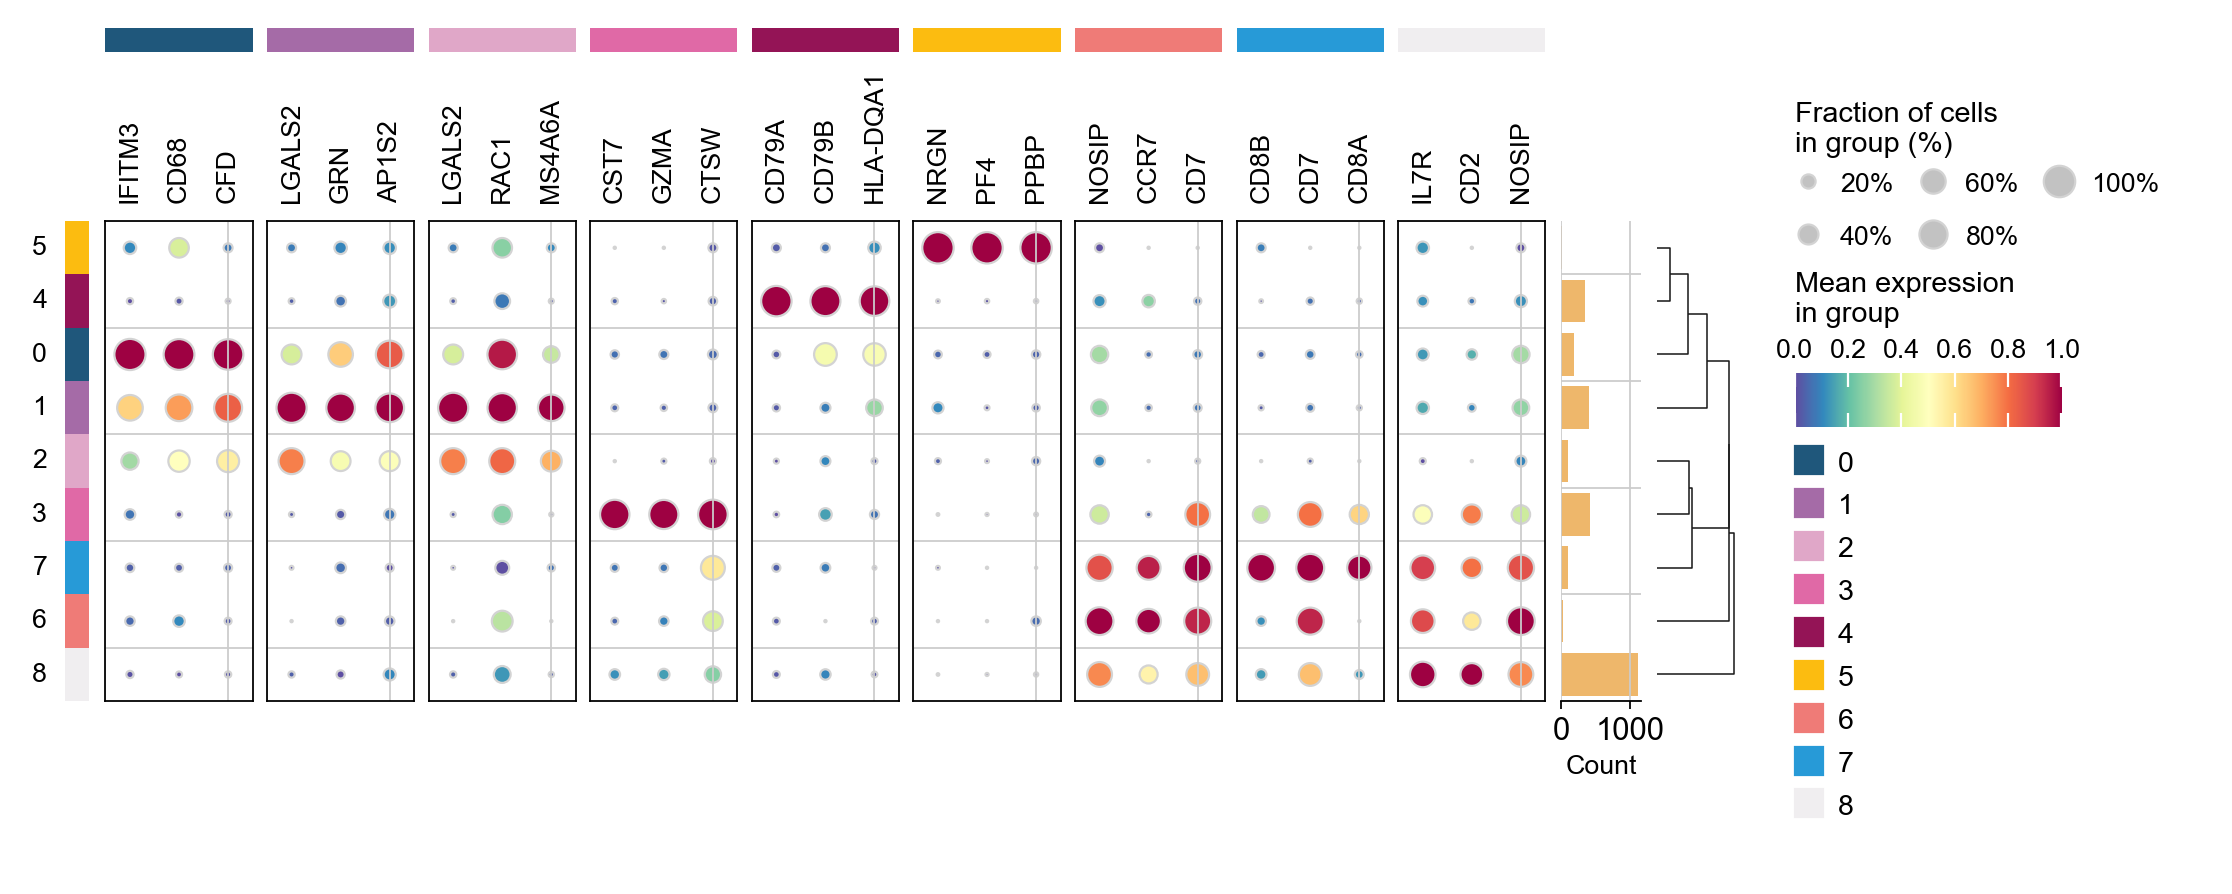

In [49]:
sc.tl.dendrogram(adata,'leiden',use_rep='scaled|original|X_pca')
sc.tl.rank_genes_groups(adata, 'leiden', use_rep='scaled|original|X_pca',
                        method='t-test',use_raw=False,key_added='leiden_ttest')
ov.pl.rank_genes_groups_dotplot(adata,groupby='leiden',
                                cmap='Spectral_r',key='leiden_ttest',
                                standard_scale='var',n_genes=3)

cosg is also considered to be a better algorithm for finding marker genes. Here, omicverse provides the calculation of cosg

Paper: [Accurate and fast cell marker gene identification with COSG](https://academic.oup.com/bib/advance-article-abstract/doi/10.1093/bib/bbab579/6511197?redirectedFrom=fulltext)

Code: https://github.com/genecell/COSG


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
**finished identifying marker genes by COSG**


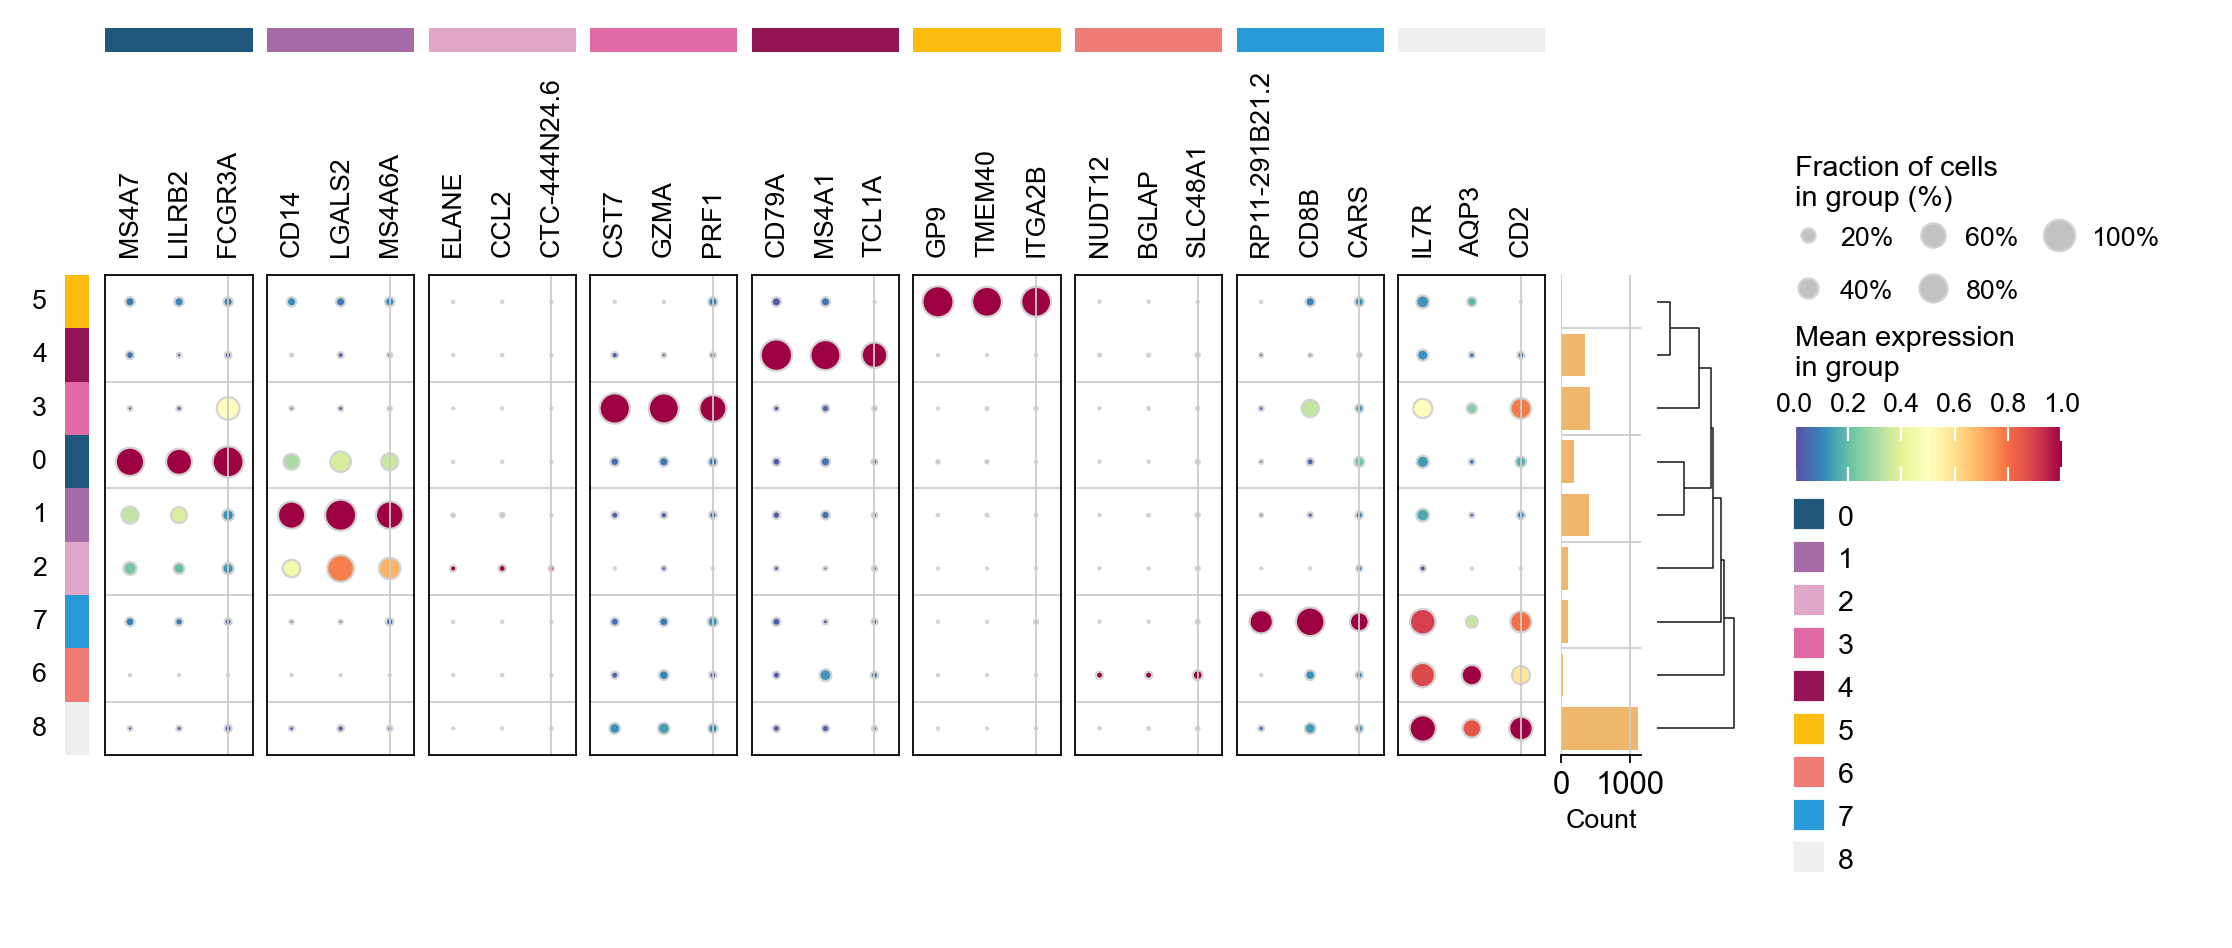

In [50]:
sc.tl.rank_genes_groups(adata, groupby='leiden', 
                        method='t-test',use_rep='scaled|original|X_pca',)
ov.single.cosg(adata, key_added='leiden_cosg', groupby='leiden')
ov.pl.rank_genes_groups_dotplot(adata,groupby='leiden',
                                cmap='Spectral_r',key='leiden_cosg',
                                standard_scale='var',n_genes=3)